# Spreading Cell Division Butter 

In [236]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import seaborn as sns
import cbbtn_utilities as cb
sns.set()
sns.set_context('talk')
%matplotlib inline

Let $\nu_t$, $e_t$, and $f_t$ be the number of verticies, edges, and faces after cell division $t$. Assuming uniform cell division times, The total number of faces (cells) will double with each cell division, 
$$
f_t = 2 f_{t - 1}
$$

Each cell division results in two new vertices and three edges, the number of vertices at time t is

$$
\nu_t = \nu_{t -1} + 2  f_{t - 1}
$$

and the number of edges is

$$
e_t = e_{t -1} + 3 f_{t - 1}
$$

Neglecting boundary conditions inthe long time limit, the average number of sides $s$ at division $t$

$$
s_t = {2(e_{t -1} + 3 f_{t-1}) \over 2 f_{t-1}} = {s_{t-1} \over 2} + 3
$$

The recurrence system is sovable for the state of the epithelian network as a function of the initial network at time $t = 0$ as

$$
s_t = 6 + 2^{-t}(s_0 - 6)
$$

This shows that the average number of cell sides exponetially approaches six, consistent iwth Euler's theorem. 

This can be modeled using a discrete markov process. The state of a cell $s$  can be defined as its number of sides, which is greater than 3 (no triangular cells). The probability of an $s$ sided cell $p_{s}$ at generation $t$ can be described by an infinite row vector 

$$
\vec{p}^{(t)} = [p_4, p_5, p_6, p_7, p_8, p_9, \dots]
$$

The state dynamics can be described as 

$$
\vec{p}^{(t + 1)} = \vec{p}^{(t)} \mathbf{PS}
$$

where P and S are probabalistic transition matrices. The entry $\mathbf{P}_{i,j}$ describes the probability of cell with $i$ sides will become a cell with $j$ sides after cell division. The shift matrix $\mathbf{S}$ comes from a topological argument that cells will, on average, **gain** one side from the division of neighboring cells. THe shift matrix is therefore defined only on the diagonal with $0$ and $1$. 

Therefore, given a distribution of polygonal cell types $\vec{p}^{(t)}$,we can compute the new distribution after a single round of division.


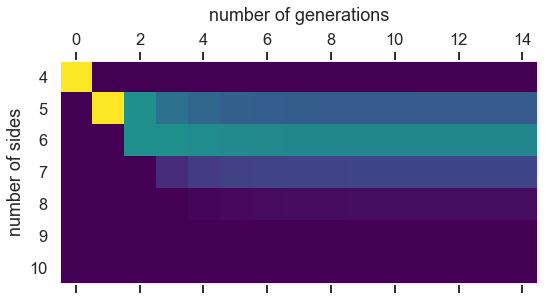

In [288]:
# Define the parameters
n_sides = 7 # Redifining index 0 as minimum 4 sides.
n_gen = 15 

# Set up the transition matrix and normalize. 
P = scipy.linalg.pascal(n_sides, exact=False, kind='lower')
S = np.zeros_like(P)
for i in range(n_sides - 1):
    S[i, i+1] = 1
for i in range(n_sides):
    P[i, :] = P[i, :] / np.sum(P[i, :])
    
# Define the probability and the intial condition.
prob = np.zeros((n_sides, n_gen))

# Set the initial condition. 
prob[0, 0] = 1.0

# Loop through each generation
for t in range(1, n_gen):       
    # Loop through
    for j in range(1, n_sides - 1):
        # Compute the probability of getting a vertex 
        prob[j, t] = np.sum(prob[:, t-1] * P[:, j-1])
   
plt.matshow(prob, cmap='viridis') 
plt.grid(False)
plt.title('number of generations', y=1.15)
plt.ylabel('number of sides')
plt.yticks(ticks=np.arange(n_sides), labels=['4', '5', '6', '7', '8', '9', '10'])
plt.savefig('gibson_butter.png', dpi=300, bbox_inches='tight')

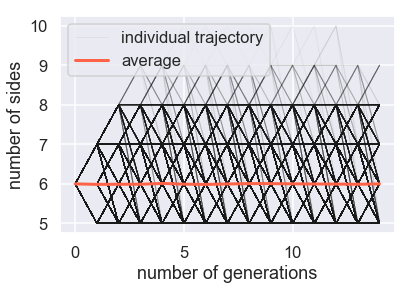

In [289]:
# Gillespie!
n_gen = 15 
n_sim = 10000
sides = np.zeros((n_sim, n_gen))
sides[:, 0] = 6
min_sides = 4
for i in range(n_sim):
    for j in range(1, n_gen):
        # Define that you have to have a minimum of three sides. 
        parent_sides = sides[i, j-1] - min_sides
        sides[i, j] =  np.random.binomial(parent_sides, p=0.5) + min_sides + 1
         
for i in range(n_sim):
    if i ==0:
        label = 'individual trajectory'
    else:
        label = '__nolegend__'
    plt.plot(np.arange(n_gen), sides[i, :], color='k', lw=1, alpha = 0.05, label=label)
    
# Plot the mean.
plt.plot(np.arange(n_gen), np.mean(sides, axis=0), color='tomato', linewidth=3, label='average')
plt.xlabel('number of generations')
plt.ylabel('number of sides')
plt.legend()

In [290]:
# Compute the distribution
side_prob = np.zeros(int(np.max(sides)) + 1)
for i in range(n_sim):
    for j in range(n_gen):
        n_sides = int(sides[i, j])
        side_prob[n_sides] += 1

# Normalize it
side_prob = side_prob / np.sum(side_prob)

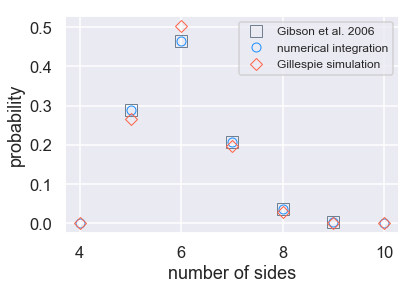

In [295]:
# Define the gibson counts. 
gibson_prob = [0.2888, 0.4640, 0.2085, 0.0359, 0.0028]
gibson_sides = [5, 6, 7, 8, 9]

# Get the integration distribution. 
butter_prob = prob[:, -1]
butter_sides = np.arange(0, n_sides) + 4

# Get the gillespie sides
gillespie_prob = side_prob[4:]
gillespie_sides = np.arange(4, int(np.max(sides)) +1)

# Plot the comparison. 
plt.plot(gibson_sides, gibson_prob, 's', markersize=12, markeredgecolor='slategray', markerfacecolor='none', 
         label='Gibson et al. 2006')
plt.plot(butter_sides, butter_prob, 'o', markeredgecolor='dodgerblue', markerfacecolor='none', 
         label='numerical integration')
plt.plot(gillespie_sides, gillespie_prob, 'D', markeredgecolor='tomato', markerfacecolor='none',
         label='Gillespie simulation')


# Add labels
plt.xlabel('number of sides')
plt.ylabel('probability')
plt.legend(fontsize=12)
plt.savefig('gibson_comparison.pdf')

In [ ]:
gill